# Topic modeling (GSDM,LDA,LSI)

In [4]:
import numpy as np 
import pandas as pd

import sys
sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
#!pip install git+https://github.com/rwalk/gsdmm.git
#!pip install gensim

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
data = pd.read_csv('/content/sample_data/tripadvisor_hotel_reviews.csv', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [17]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


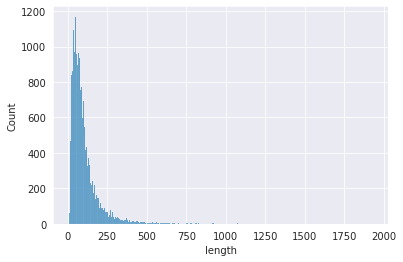

In [18]:
sns.histplot(data['length'])

In [19]:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [20]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [21]:
tokens_reviews = list(sent_to_words(data['review_list']))
tokens_reviews = make_n_grams(tokens_reviews)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [22]:
! python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 4.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [25]:
np.random.seed(0)
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)


In stage 0: transferred 15783 clusters with 6 clusters populated
In stage 1: transferred 9146 clusters with 6 clusters populated
In stage 2: transferred 5798 clusters with 6 clusters populated
In stage 3: transferred 4526 clusters with 6 clusters populated
In stage 4: transferred 4035 clusters with 6 clusters populated
In stage 5: transferred 3736 clusters with 6 clusters populated
In stage 6: transferred 3441 clusters with 6 clusters populated
In stage 7: transferred 3291 clusters with 6 clusters populated
In stage 8: transferred 3133 clusters with 6 clusters populated
In stage 9: transferred 3091 clusters with 6 clusters populated
In stage 10: transferred 2977 clusters with 6 clusters populated
In stage 11: transferred 2857 clusters with 6 clusters populated
In stage 12: transferred 2778 clusters with 6 clusters populated
In stage 13: transferred 2774 clusters with 6 clusters populated
In stage 14: transferred 2717 clusters with 6 clusters populated
In stage 15: transferred 2721 clus

In [26]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [27]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [1292  926 4233 5146 2803 6091]

Most important clusters (by number of docs inside): [5 3 2 4 0 1]

Cluster 5 : [('resort', 7658), ('food', 7044), ('pool', 6101), ('beach', 5470), ('restaurant', 5272), ('night', 5269), ('people', 4931), ('want', 3772), ('drink', 3514), ('water', 3363)]

Cluster 3 : [('night', 3088), ('breakfast', 2154), ('bed', 2093), ('walk', 1802), ('bathroom', 1684), ('restaurant', 1679), ('view', 1661), ('area', 1606), ('price', 1483), ('floor', 1459)]

Cluster 2 : [('breakfast', 2274), ('walk', 2183), ('night', 2177), ('restaurant', 1634), ('area', 1181), ('recommend', 1014), ('bathroom', 966), ('view', 932), ('city', 900), ('price', 847)]

Cluster 4 : [('night', 1854), ('breakfast', 1617), ('bed', 1148), ('bathroom', 1124), ('walk', 987), ('floor', 869), ('area', 782), ('view', 782), ('price', 762), ('restaurant', 713)]

Cluster 0 : [('night', 1071), ('tell', 678), ('desk', 570), ('bed', 486), ('pay', 445), ('charge', 405), ('probl

In [28]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [29]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [30]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,nice hotel expensive parking got good deal sta...,type 2,4,"[parking, deal, anniversary, evening, review, ..."
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, decide, chain, shoot, anniversary, pa..."
2,nice rooms not 4* experience hotel monaco seat...,type 2,3,"[experience, level, positive, bathroom, bed, h..."
3,"unique, great stay, wonderful time hotel monac...",type 2,5,"[stroll, downtown, shopping, area, sign, anima..."
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[seahawk, game, building, complain, website, s..."


In [31]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

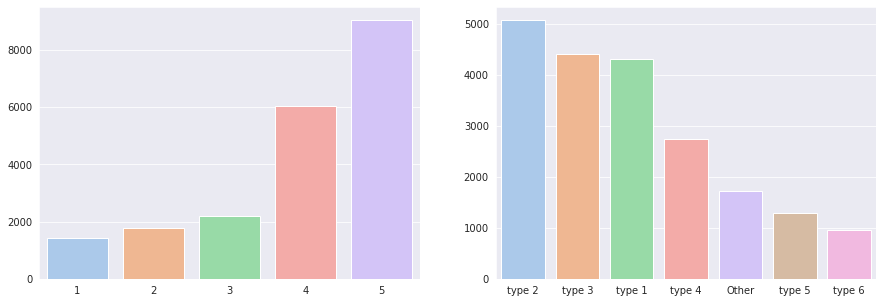

In [32]:
rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])

In [33]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [34]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

,Text,Topic,Rating,Lemma-text,len
0,nice hotel expensive parking got good deal sta...,type 2,4,"[parking, deal, anniversary, evening, review, ...",87
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, decide, chain, shoot, anniversary, pa...",250
2,nice rooms not 4* experience hotel monaco seat...,type 2,3,"[experience, level, positive, bathroom, bed, h...",217
3,"unique, great stay, wonderful time hotel monac...",type 2,5,"[stroll, downtown, shopping, area, sign, anima...",89
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[seahawk, game, building, complain, website, s...",191


Text(0.5, 1.0, 'Types')

Text(0.5, 1.0, 'Ratings')

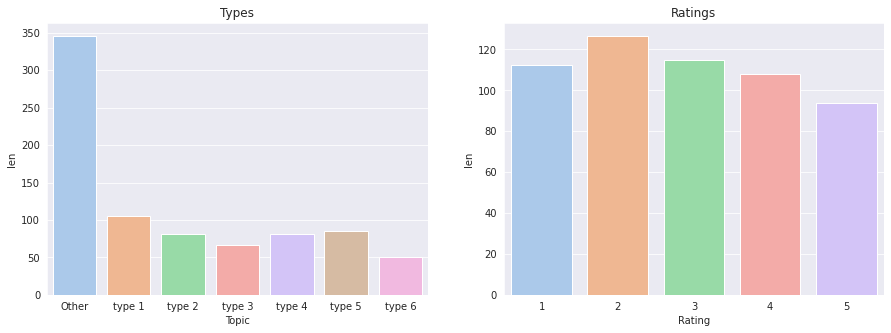

In [35]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

Text(0.5, 1.0, 'Mean rating for each type')

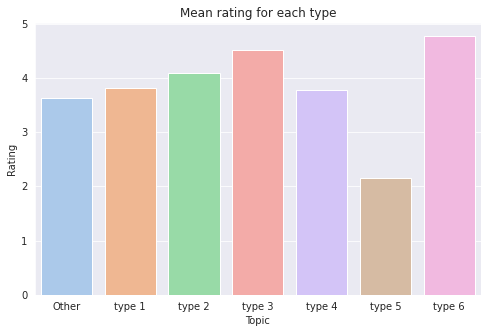

In [36]:
result.Rating = pd.to_numeric(result.Rating)
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

In [37]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))
result = result.drop('Lemma-text', axis=1)

from wordcloud import WordCloud 
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

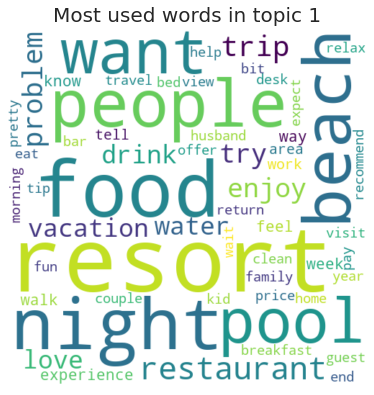

In [38]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

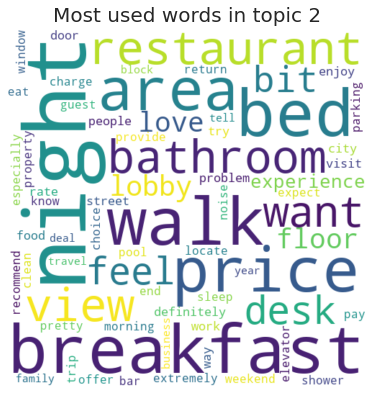

In [39]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

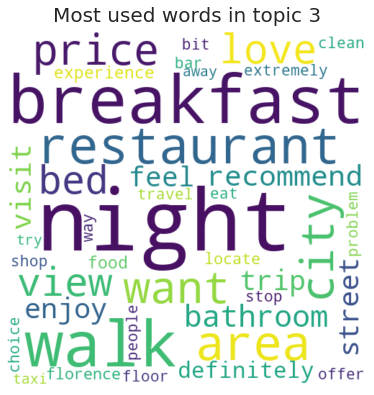

In [40]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

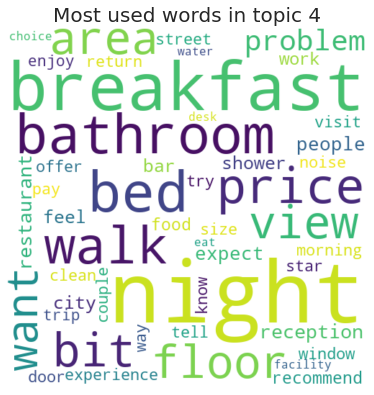

In [41]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

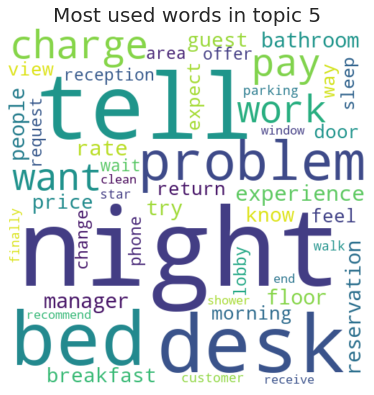

In [42]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

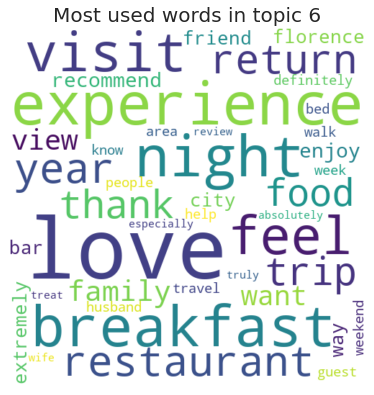

In [43]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

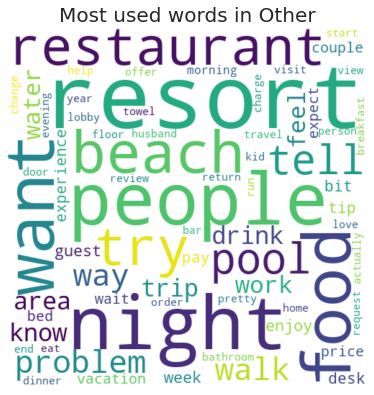

In [44]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

In [45]:
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [48]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)


model created
0.4365727609025683
model created
0.42623691055152046
model created
0.44181476613114884
model created
0.43856181559495483
model created
0.5134160433787788


Text(0.5, 0, 'Number of topics')

Text(0, 0.5, 'Coherence')

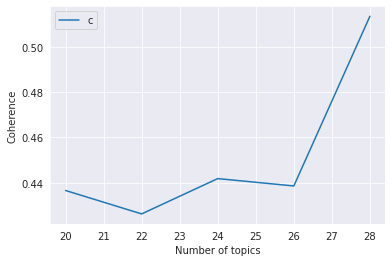

In [49]:
import matplotlib.pyplot as plt
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(25,
  '0.005*"night" + 0.004*"pool" + 0.004*"walk" + 0.004*"restaurant" + 0.004*"breakfast" + 0.004*"food" + 0.004*"bed" + 0.004*"bathroom" + 0.004*"price" + 0.004*"bar"'),
 (11,
  '0.006*"harbour" + 0.003*"night" + 0.003*"hospital" + 0.002*"month" + 0.002*"asap" + 0.002*"feel" + 0.002*"renew" + 0.002*"bed" + 0.002*"price" + 0.002*"business"'),
 (9,
  '0.003*"golf" + 0.002*"wipe" + 0.002*"months_ago" + 0.002*"graduation" + 0.002*"aunt" + 0.002*"season" + 0.001*"kleenex" + 0.001*"associate" + 0.001*"breakfast" + 0.001*"walk"'),
 (22,
  '0.008*"sydney" + 0.003*"studio" + 0.002*"restrict" + 0.002*"feb" + 0.002*"glitch" + 0.002*"sky" + 0.001*"pricier" + 0.001*"pin" + 0.001*"plasma_tv" + 0.001*"cotton"'),
 (0,
  '0.003*"restaurant" + 0.003*"area" + 0.003*"walk" + 0.002*"breakfast" + 0.002*"night" + 0.002*"view" + 0.002*"week" + 0.002*"food" + 0.002*"silla" + 0.002*"definitely"'),
 (23,
  '0.002*"valentine" + 0.002*"nail" + 0.002*"change_pace" + 0.002*"factory" + 0.002*"chandelier" + 0.002

In [52]:
#!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e4e1999e45ad44da5f440393a077de401b264af3c07e6507c1c6c8633c13bf71
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [57]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [58]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [59]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,25.0,0.4057,"night, pool, walk, restaurant, breakfast, food...","[parking, deal, anniversary, evening, review, ..."
1,1,25.0,0.3981,"night, pool, walk, restaurant, breakfast, food...","[charge, decide, chain, shoot, anniversary, pa..."
2,2,25.0,0.5352,"night, pool, walk, restaurant, breakfast, food...","[experience, level, positive, bathroom, bed, h..."
3,3,25.0,0.4866,"night, pool, walk, restaurant, breakfast, food...","[stroll, downtown, shopping, area, sign, anima..."
4,4,25.0,0.3759,"night, pool, walk, restaurant, breakfast, food...","[seahawk, game, building, complain, website, s..."
5,5,11.0,0.2730,"harbour, night, hospital, month, asap, feel, r...","[weekend, attend, friend, husband, celebrate, ..."
6,6,2.0,0.5144,"area, walk, price, restaurant, tourist, night,...","[husband, spend, night, business, trip, chance..."
7,7,25.0,0.4535,"night, pool, walk, restaurant, breakfast, food...","[housekeeping, quality, chock, feel, home, exp..."
8,8,25.0,0.4797,"night, pool, walk, restaurant, breakfast, food...","[cruise, decorate, remodel, build, everytime, ..."
9,9,25.0,0.3584,"night, pool, walk, restaurant, breakfast, food...","[reception, bed, particularly, like, reception..."


<Figure size 1440x360 with 0 Axes>

Text(0, 9, '9.0')

Text(0, 9, '10.0')

Text(0, 9, '12.0')

Text(0, 9, '15.0')

Text(0, 9, '19.0')

Text(0, 9, '23.0')

Text(0, 9, '24.0')

Text(0, 9, '26.0')

Text(0, 9, '27.0')

Text(0, 9, '28.0')

Text(0, 9, '30.0')

Text(0, 9, '32.0')

Text(0, 9, '44.0')

Text(0, 9, '60.0')

Text(0, 9, '71.0')

Text(0, 9, '109.0')

Text(0, 9, '126.0')

Text(0, 9, '145.0')

Text(0, 9, '194.0')

Text(0, 9, '264.0')

Text(0, 9, '310.0')

Text(0, 9, '508.0')

Text(0, 9, '587.0')

Text(0, 9, '2629.0')

Text(0, 9, '3823.0')

Text(0, 9, '11315.0')

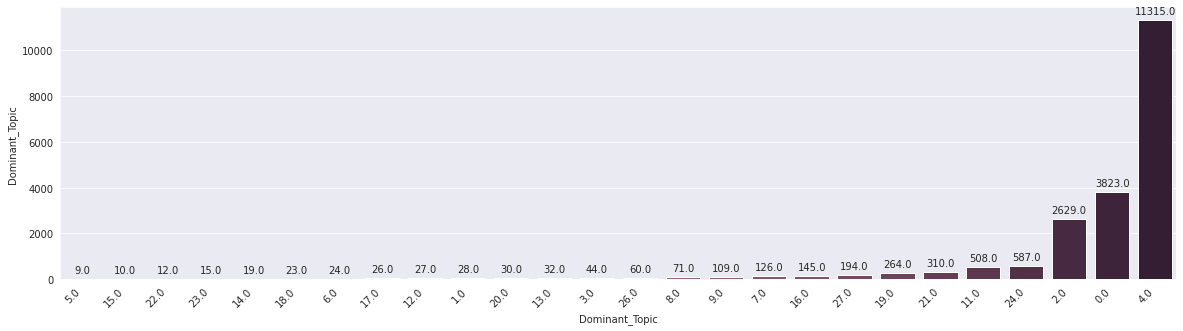

In [60]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)


plt.figure(figsize=(20,5))
ax = sns.barplot(x=topic_counts.index, y=topic_counts, data=topic_counts,  palette="ch:.25")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax = ax.set_xticklabels(topic_counts.index, rotation = 45, ha="right")

In [61]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(24)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6901,"restaurant, area, walk, breakfast, night, view...","[expense, judge, experience, clean, somewhat, ..."
1,1.0,0.4985,"mate, rubbish, apartment, rennovate, distace, ...","[bit, appear, recently, rennovate, want, site,..."
2,2.0,0.6767,"area, walk, price, restaurant, tourist, night,...","[resort, return, return, like, resort, return,..."
3,3.0,0.5258,"raffle, brilliant, favourite, century, oblige,...","[family, night, experience, absolutely, totall..."
4,4.0,0.7608,"bali, food, pool, beach, resort, restaurant, n...","[picture, displace, disappoint, read, review, ..."
5,5.0,0.4745,"stopover, authenticity, hell, stead, escalate,...","[number, visit, relais_bosquet, station, resta..."
6,6.0,0.5018,"newly, blackout, helpfulness, artist, pic, din...","[love, celebrity, recently, grammie, problem, ..."
7,7.0,0.6019,"barcelo, mtr, alsoi, centrally, conveniently, ...","[experience, wantie, experience, city, feel, t..."
8,8.0,0.6130,"bingo, underground, designer, willing_help, sm...","[spend, night, station, rikjsmuseum, walk, des..."
9,9.0,0.5583,"golf, wipe, months_ago, graduation, aunt, seas...","[night, reading_review, year, believe, th, flo..."


In [62]:
from gensim.models import LsiModel
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)

model created
0.4250768027422526
model created
0.40749501979368297
model created
0.3887635238957628
model created
0.39990513339671463
model created
0.38555107100534636
model created
0.36813971769553183
model created
0.35405182220611625
model created
0.3539215161334289
model created
0.35849216798108086
model created
0.33752548794114967
model created
0.3336680285029928
model created
0.33125209884768636
model created
0.3212820277325999
model created
0.32372225733394666


In [ ]:
limit, start, step = 30, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [64]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

[(0,
  '0.176*"resort" + 0.138*"night" + 0.136*"food" + 0.135*"pool" + 0.134*"restaurant" + 0.124*"beach" + 0.124*"walk" + 0.120*"breakfast" + 0.117*"people" + 0.116*"area"'),
 (1,
  '-0.504*"resort" + -0.260*"beach" + -0.182*"pool" + -0.179*"food" + 0.163*"breakfast" + -0.158*"vacation" + 0.139*"city" + 0.130*"bathroom" + 0.126*"view" + 0.122*"walk"')]

[(0,
  '0.176*"resort" + 0.138*"night" + 0.136*"food" + 0.135*"pool" + 0.134*"restaurant" + 0.124*"beach" + 0.124*"walk" + 0.120*"breakfast" + 0.117*"people" + 0.116*"area"'),
 (1,
  '-0.504*"resort" + -0.260*"beach" + -0.182*"pool" + -0.179*"food" + 0.163*"breakfast" + -0.158*"vacation" + 0.139*"city" + 0.130*"bathroom" + 0.126*"view" + 0.122*"walk"')]